In [ ]:
!pip install tensorflow_io==0.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
CAPUCHIN_FILE = os.path.join('drive', 'MyDrive','Z by HP Unlocked Challenge 3','Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('drive', 'MyDrive','Z by HP Unlocked Challenge 3','Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

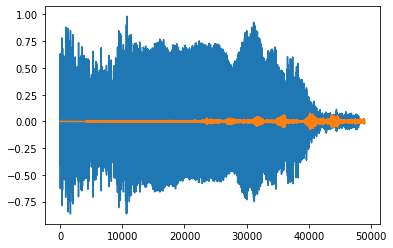

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
POS = os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Parsed_Capuchinbird_Clips')
NEG = os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Parsed_Not_Capuchinbird_Clips')

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
lengths = []
for file in os.listdir(os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [ ]:
print(lengths)
print(tf.math.reduce_mean(lengths))
print(tf.math.reduce_min(lengths))
print(tf.math.reduce_max(lengths))

[64000, 64000, 48000, 64000, 40000, 56000, 48000, 56000, 48000, 56000, 64000, 64000, 56000, 48000, 56000, 64000, 56000, 64000, 56000, 64000, 56000, 56000, 64000, 56000, 56000, 40000, 56000, 48000, 56000, 64000, 64000, 64000, 56000, 48000, 64000, 64000, 56000, 56000, 56000, 40000, 32000, 64000, 48000, 56000, 48000, 48000, 48000, 40000, 56000, 56000, 48000, 48000, 48000, 40000, 40000, 40000, 64000, 56000, 56000, 64000, 56000, 48000, 48000, 48000, 48000, 48000, 48000, 56000, 56000, 40000, 48000, 56000, 56000, 56000, 56000, 72000, 64000, 48000, 40000, 56000, 48000, 56000, 56000, 56000, 64000, 56000, 48000, 48000, 56000, 56000, 64000, 64000, 64000, 40000, 56000, 40000, 64000, 48000, 48000, 48000, 56000, 64000, 64000, 64000, 48000, 48000, 48000, 48000, 48000, 56000, 56000, 56000, 56000, 64000, 64000, 64000, 48000, 56000, 55999, 56000, 32000, 32000, 40000, 56000, 56000, 48000, 40000, 40000, 64000, 56000, 48000, 48000, 40000, 56000, 48000, 48000, 48000, 64000, 56000, 55999, 48000, 48000, 72000

In [ ]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

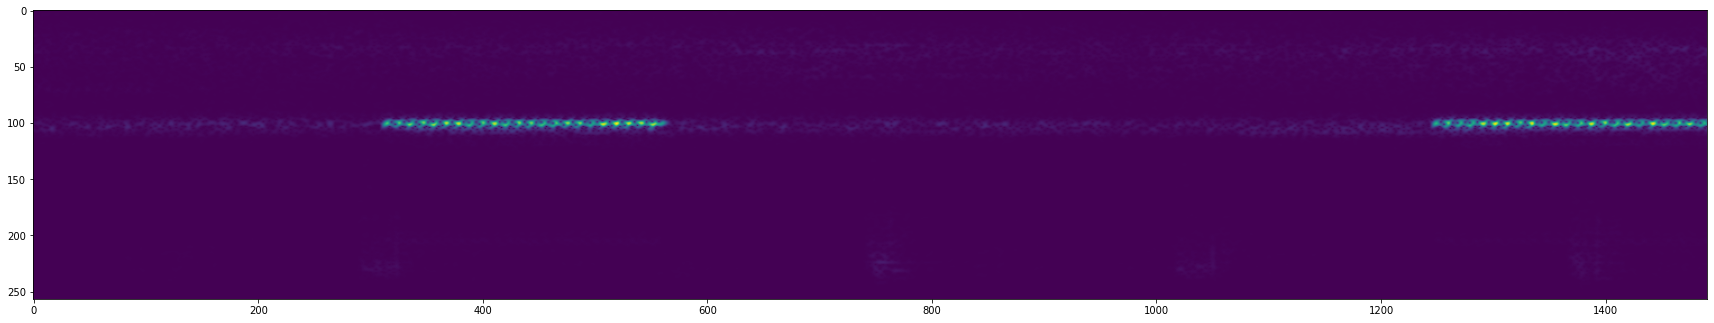

In [ ]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 1000)
data = data.batch(16)  #can reduce time taken to train the model. Select few data points in one iteration.
data = data.prefetch(8)  #same as we learn in processor designs

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape   #think this like 16 gray scale images with 1491 x 257 size

(16, 1491, 257, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

The below cell for making the model creates a huge number of learnable parameters and therefore the ram exceeds. Hence added two max pooling layers and the new model is the cell below to this commented cell

In [ ]:
# model = Sequential()
# model.add(Conv2D(16,(3,3), activation = 'relu', input_shape = (1491,257,1)))
# model.add(Conv2D(16,(3,3), activation = 'relu'))
# model.add(Flatten())
# model.add(Dense(128, activation = 'relu'))
# model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(1491,257,1)),
        layers.Conv2D(16,(3,3), activation = 'relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(16,(3,3), activation = 'relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128,activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid'),

    ]
)

In [ ]:
model.compile('Adam', loss = 'BinaryCrossentropy', metrics = [tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 368032)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)


Epoch 1/4
36/36 [==============================] - 135s 4s/step - loss: 0.6880 - recall_1: 0.8506 - precision_1: 0.8239 - val_loss: 0.3319 - val_recall_1: 0.9167 - val_precision_1: 0.9706
Epoch 2/4
36/36 [==============================] - 134s 4s/step - loss: 0.0579 - recall_1: 0.9515 - precision_1: 0.9752 - val_loss: 0.0132 - val_recall_1: 0.9857 - val_precision_1: 1.0000
Epoch 3/4
36/36 [==============================] - 132s 4s/step - loss: 0.0161 - recall_1: 0.9821 - precision_1: 1.0000 - val_loss: 0.0113 - val_recall_1: 0.9833 - val_precision_1: 1.0000
Epoch 4/4
36/36 [==============================] - 132s 4s/step - loss: 0.0050 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 0.0011 - val_recall_1: 1.0000 - val_precision_1: 1.0000


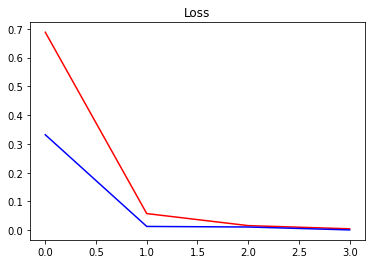

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

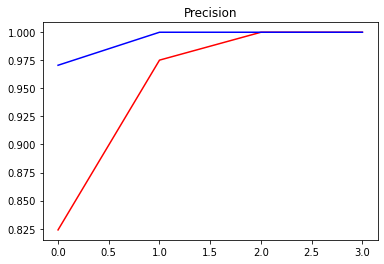

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

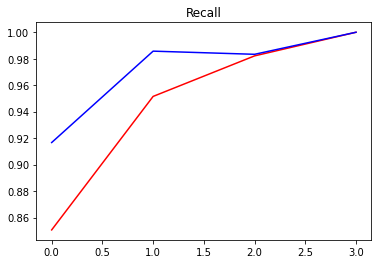

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

In [ ]:
x_test , y_test = test.as_numpy_iterator().next()

In [ ]:
y_hat = model.predict(x_test)

In [ ]:
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [ ]:
print('y_test = ', y_test.astype(int))
print('predicted y_hat = ', y_hat)

y_test =  [0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0]
predicted y_hat =  [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]


In [169]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [172]:
mp3 = os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Forest Recordings',"recording_01.mp3")


In [173]:
wav = load_mp3_16k_mono(mp3)


In [174]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [175]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [177]:
y_hat = model.predict(audio_slices)
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [178]:
from itertools import groupby

In [179]:
y_hat = [key for key, group in groupby(y_hat)]
calls = tf.math.reduce_sum(y_hat).numpy()

In [180]:
calls

3

In [183]:
results = {}
for file in os.listdir(os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Forest Recordings')):
    FILEPATH = os.path.join('drive','MyDrive','Z by HP Unlocked Challenge 3','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    y_hat = model.predict(audio_slices)
    
    results[file] = y_hat

In [ ]:
results

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.9 else 0 for prediction in logits]
# class_preds

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
# postprocessed

In [188]:
import csv


In [192]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])